In [1]:
#https://www.kaggle.com/datasets/ahmedabbas757/coffee-sales
# import kagglehub

# # Defina o caminho onde deseja salvar o dataset
# destination_path = "/home/kelvin/"  # Altere para o caminho desejado

# # Baixe o dataset na pasta especificada
# path = kagglehub.dataset_download("ahmedabbas757/coffee-sales")

# print("Path to dataset files:", path)


### Interpretando o dataset

In [2]:
import pandas as pd
dataframe = pd.read_excel("Coffee Shop Sales.xlsx")

In [3]:
dataframe.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


### Vamos ver agora a proporção de cada Classe

In [4]:
columns = dataframe.columns.to_list()
for col in columns:
    print(dataframe[col].value_counts(normalize=True) * 100)
    print("-----------")

transaction_id
149456    0.000671
1         0.000671
2         0.000671
3         0.000671
4         0.000671
            ...   
32        0.000671
33        0.000671
34        0.000671
35        0.000671
36        0.000671
Name: proportion, Length: 149116, dtype: float64
-----------
transaction_date
2023-06-19    0.900641
2023-06-16    0.892594
2023-06-18    0.865098
2023-06-13    0.859063
2023-06-27    0.856380
                ...   
2023-02-06    0.327933
2023-01-30    0.322568
2023-01-28    0.315191
2023-01-31    0.309826
2023-01-29    0.307814
Name: proportion, Length: 181, dtype: float64
-----------
transaction_time
09:31:15    0.027495
08:15:41    0.026825
08:19:08    0.025484
11:40:03    0.024142
10:11:25    0.024142
              ...   
14:21:29    0.000671
14:37:47    0.000671
16:49:24    0.000671
17:07:57    0.000671
12:48:24    0.000671
Name: proportion, Length: 25762, dtype: float64
-----------
transaction_qty
1    58.450468
2    39.326430
3     2.198959
4     0.015424
8  

### Onde há valores nulos?

In [5]:
print(dataframe.isnull().sum())

transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64


### Normalização dos dados

In [6]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Tratando as datas
dataframe["transaction_date"] = pd.to_datetime(dataframe["transaction_date"])
dataframe["Year"] = dataframe["transaction_date"].dt.year
dataframe["Month"] = dataframe["transaction_date"].dt.month
dataframe["Day"] = dataframe["transaction_date"].dt.day
dataframe.drop(columns=["transaction_date"], inplace=True)

# Tratando os horários para o formato cíclico (Seno/Cosseno)
dataframe["transaction_time"] = pd.to_datetime(dataframe["transaction_time"], format="%H:%M:%S")
dataframe["hour"] = dataframe["transaction_time"].dt.hour
dataframe["sin_hour"] = np.sin(2 * np.pi * dataframe["hour"] / 24)
dataframe["cos_hour"] = np.cos(2 * np.pi * dataframe["hour"] / 24)

#Dropando as colunas auxiliares / descartaveis de horas
# dataframe.drop(columns=["transaction_time", "hour"], inplace=True)


# Criando um label (ID) para os valores em string
label_encoder = LabelEncoder()
dataframe["store_location"] = label_encoder.fit_transform(dataframe["store_location"])
dataframe["product_category"] = label_encoder.fit_transform(dataframe["product_category"])
dataframe["product_type"] = label_encoder.fit_transform(dataframe["product_type"])
dataframe["product_detail"] = label_encoder.fit_transform(dataframe["product_detail"])

In [7]:
dataframe.head()

,transaction_id,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,Year,Month,Day,hour,sin_hour,cos_hour
0,1,1900-01-01 07:06:11,2,5,2,32,3.0,2,13,32,2023,1,1,7,0.965926,-0.258819
1,2,1900-01-01 07:08:56,2,5,2,57,3.1,8,4,71,2023,1,1,7,0.965926,-0.258819
2,3,1900-01-01 07:14:04,2,5,2,59,4.5,4,17,20,2023,1,1,7,0.965926,-0.258819
3,4,1900-01-01 07:20:24,1,5,2,22,2.0,2,10,60,2023,1,1,7,0.965926,-0.258819
4,5,1900-01-01 07:22:41,2,5,2,57,3.1,8,4,71,2023,1,1,7,0.965926,-0.258819


### O que vamos tentar prever?

Possíveis problemas:

- Existe um padrão de horário e quantidade de vendas em certas lojas?
- Há lojas ou produtos que têm padrões de vendas incomuns (outliers)?
- Os clientes seguem padrões de compras baseados em preço e quantidade?
- Existe um grupo de produtos frequentemente comprados juntos?


### Identificando Padrões

### 1 - Verificando os diferentes grupos de transações
Dado a categoria do produto, o tipo de produto, o preço unitário e a quantidade vendida.

#### Padronizando os dados

In [8]:
from sklearn.preprocessing import StandardScaler

# Colunas a serem estudadas
features = ["product_category", "product_type", "unit_price", "transaction_qty"]
X = dataframe[features]

# Padronizando os dados
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

#### KMEANS

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=3, random_state=0).fit(data_scaled)
kmeans.labels_

array([2, 2, 2, ..., 0, 0, 2], dtype=int32)

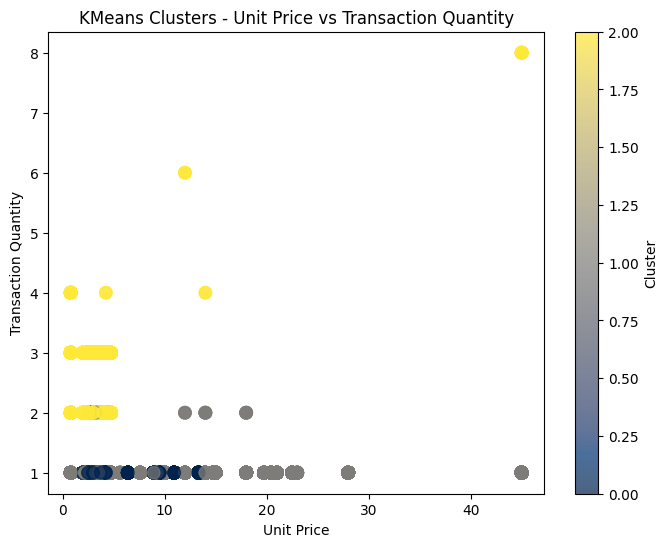

In [10]:
plt.figure(figsize=(8, 6))
# Selecionando duas colunas para plotar: unit_price e transaction_qty
scatter = plt.scatter(
  dataframe["unit_price"], 
  dataframe["transaction_qty"], 
  c=kmeans.labels_, 
  cmap='cividis', 
  s=80,
  alpha=0.7
)

plt.xlabel('Unit Price')
plt.ylabel('Transaction Quantity')
plt.title('KMeans Clusters - Unit Price vs Transaction Quantity')
plt.colorbar(scatter, label='Cluster')
plt.show()

Podemos observar no gráfico alguns outliers, como por exemplo uma transação de um produto com um valor alto em alta quantidade, o que não é comum!

### DBSCAN

In [16]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.15, min_samples=5)
clusters_dsbcan = dbscan.fit_predict(data_scaled)
unique_clusters = np.unique(clusters_dsbcan)
len(unique_clusters)

115

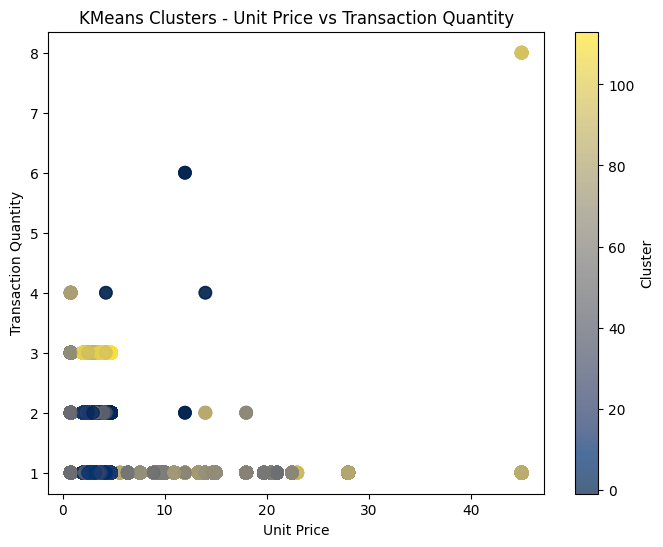

In [14]:
plt.figure(figsize=(8, 6))
# Selecionando duas colunas para plotar: unit_price e transaction_qty
scatter = plt.scatter(
  dataframe["unit_price"], 
  dataframe["transaction_qty"], 
  c=clusters_dsbcan, 
  cmap='cividis', 
  s=80,
  alpha=0.7
)

plt.xlabel('Unit Price')
plt.ylabel('Transaction Quantity')
plt.title('KMeans Clusters - Unit Price vs Transaction Quantity')
plt.colorbar(scatter, label='Cluster')
plt.show()

O dbscan identificou 115 tipo de clusters! Lembrando que o dataset possui um tamanho de 149 mil registros

Lembrando que, não foi feito nem um estudo para a definição do epsilon e do min_samples (Até o momento).